In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from tqdm import tqdm 

def load_data(tcga=True):
    if tcga: 
        file_path_data = "TCGAdata.txt"
        file_path_labels = "TCGAlabels.txt"
        delimiter=' '
    else:
        file_path_data = "CATSnDOGS.csv"
        file_path_labels = "Labels.csv"
        delimiter=',' 
    df_data = pd.read_csv(file_path_data, delimiter=delimiter, header=0, quotechar='"')
    df_labels = pd.read_csv(file_path_labels, delimiter=delimiter, header=0, quotechar='"')
    return df_data.values, df_labels.values 

def standardize(train_data, test_data):
    sc = StandardScaler()
    train_data = sc.fit_transform(train_data)
    test_data = sc.transform(test_data)
    return train_data, test_data

def feature_selection(data, labels, classifier):
    sel = VarianceThreshold(threshold=5.0)
    data_cleaned = sel.fit_transform(data)
    #X_test = sel.transform(X_test)

    feature_range = range(1, data_cleaned.shape[1] + 1, 20)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    num_features = [] 
    for n_features in feature_range:
        anova = SelectKBest(score_func=f_classif, k=n_features)
        data_feature_reduced = anova.fit_transform(data_cleaned, labels)
        cv_scores = cross_val_score(classifier, data_feature_reduced, labels, cv=kf)
        mean_cv_score = np.mean(cv_scores)
        scores.append(mean_cv_score)
        num_features.append(n_features)
    
    print(f"#features: {num_features[np.where(scores == np.max(scores))[0][0]]}, score: {np.max(scores)}") 
    return scores, num_features

(array([816., 362., 230., 139., 112.,  61.,  53.,  45.,  33.,  35.,  14.,
         11.,  14.,  15.,   8.,   6.,   4.,   7.,   5.,   1.,   5.,   2.,
          6.,   1.,   2.,   0.,   2.,   3.,   1.,   1.,   1.,   1.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.]),
 array([ 0.        ,  0.63206173,  1.26412346,  1.89618519,  2.52824692,
         3.16030865,  3.79237038,  4.42443211,  5.05649384,  5.68855557,
         6.3206173 ,  6.95267903,  7.58474075,  8.21680248,  8.84886421,
         9.48092594, 10.11298767, 10.7450494 , 11.37711113, 12.00917286,
        12.64123459, 13.27329632, 13.90535805, 14.53741978, 15.16948151,
        15.80154324, 16.43360497, 17.0656667 , 17.69772843, 18.32979016,
        18.96185189, 19.59391362, 20.22597535, 20.85803708, 21.49009881,
        22.12216054, 22.75422226, 23.38628399, 24.01834572, 24.65040745,
        25.28246918, 25.91453091, 26.54659264, 27.17865437, 27.8107161 ,
 

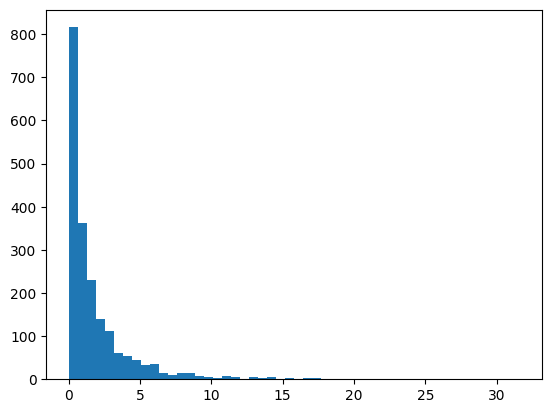

In [16]:
# Checking variance distribution 

data, labels = load_data()
plt.hist(np.var(data, axis=0), bins=50)


#features: 121, score: 0.9878766798798223


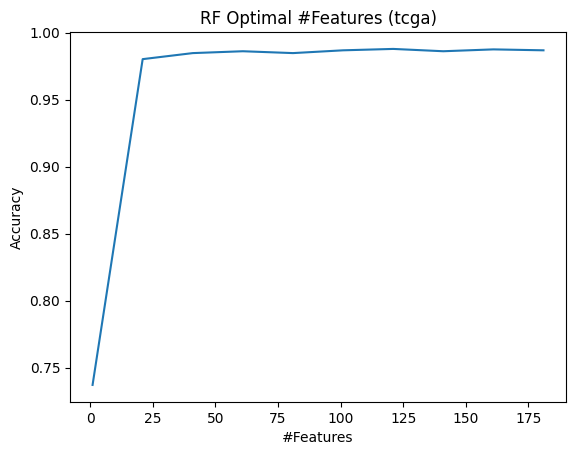

#features: 141, score: 0.9861417785587067


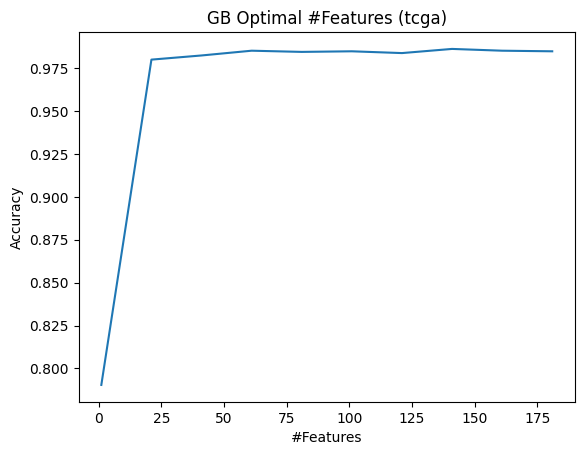

In [17]:
# searching for optimal num of features with cross val 
data, labels = load_data()
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

classifier_rf = RandomForestClassifier(n_estimators=100) 
classifier_gb = GradientBoostingClassifier(n_estimators=100) 

scores, num_features = feature_selection(data, labels.ravel(), classifier_rf)
plt.plot(num_features, scores) 
plt.title("RF Optimal #Features (tcga)")
plt.xlabel("#Features")
plt.ylabel("Accuracy")
plt.show()
scores, num_features = feature_selection(data, labels.ravel(), classifier_gb)
plt.plot(num_features, scores) 
plt.title("GB Optimal #Features (tcga)")
plt.xlabel("#Features")
plt.ylabel("Accuracy")
plt.show()

c:\Users\tussa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  83  401  497  596  642  732  816  863  984 1110 1180 1373 1557 1852
 1882] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\tussa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
100%|██████████| 100/100 [3:05:12<00:00, 111.13s/it] 


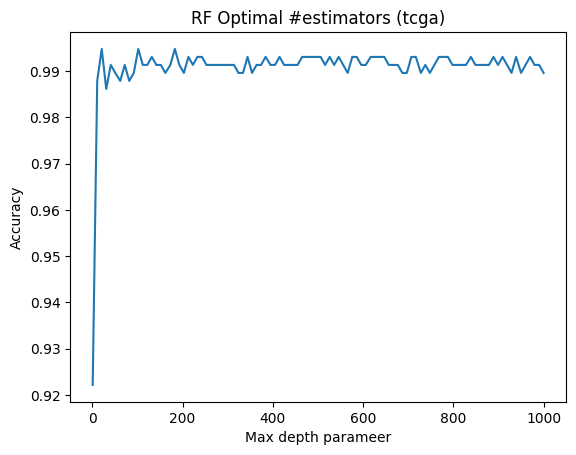

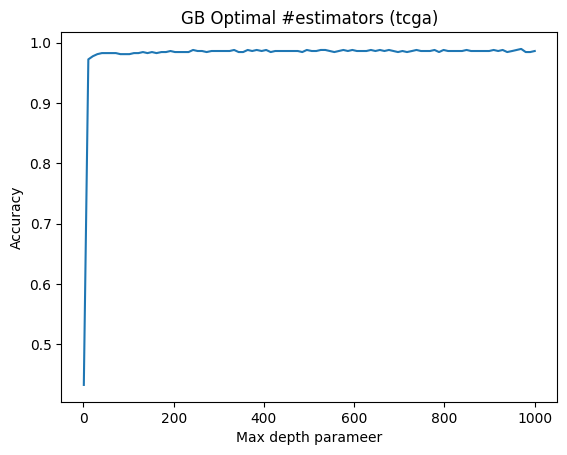

In [20]:
# searching for optimal #estimators 
data, labels = load_data()
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

anova = SelectKBest(score_func=f_classif, k=100)
X_train_feature = anova.fit_transform(X_train, y_train.ravel())
X_test_feature = anova.transform(X_test)
X_train_stand, X_test_stand = standardize(X_train_feature, X_test_feature)

accuracies_rf = []
accuracies_gb = []
estimator_range = np.linspace(1, 1000, 100)

for estimators in tqdm(estimator_range):
    classifier_rf = RandomForestClassifier(n_estimators=int(estimators)) 
    classifier_gb = GradientBoostingClassifier(n_estimators=int(estimators)) 

    classifier_rf.fit(X_train_stand, y_train.ravel())
    y_pred_test = classifier_rf.predict(X_test_stand)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracies_rf.append(accuracy)

    classifier_gb.fit(X_train_stand, y_train.ravel())
    y_pred_test = classifier_gb.predict(X_test_stand)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracies_gb.append(accuracy)


plt.plot(np.around(estimator_range).astype(int), accuracies_rf) 
plt.title("RF Optimal #Estimators (tcga)")
plt.xlabel("#Estimators")
plt.ylabel("Accuracy")
plt.show()
plt.plot(np.around(estimator_range).astype(int), accuracies_gb) 
plt.title("GB Optimal #Estimators (tcga)")
plt.xlabel("#Estimators")
plt.ylabel("Accuracy")
plt.show()

c:\Users\tussa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  83  401  497  596  642  732  816  863  984 1110 1180 1373 1557 1852
 1882] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\tussa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


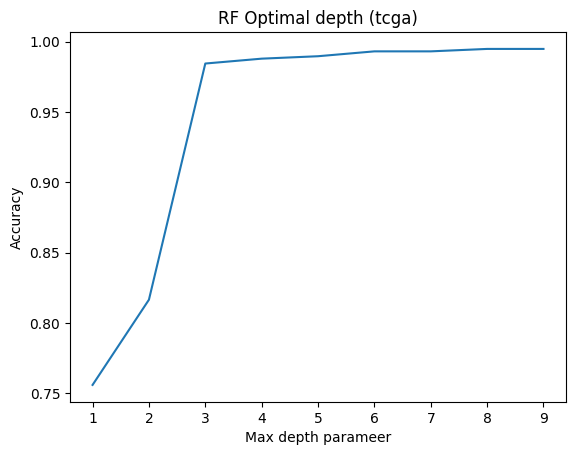

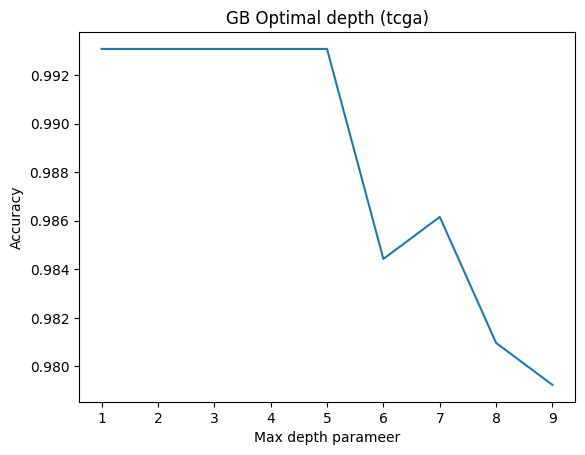

In [22]:
# searching for optimal depth 
data, labels = load_data()
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

anova = SelectKBest(score_func=f_classif, k=100)
X_train_feature = anova.fit_transform(X_train, y_train.ravel())
X_test_feature = anova.transform(X_test)
X_train_stand, X_test_stand = standardize(X_train_feature, X_test_feature)

accuracies_rf = []
accuracies_gb = []
depth_range = range(1,10)

for depth in depth_range:
    classifier_rf = RandomForestClassifier(n_estimators=100, max_depth=depth) 
    classifier_gb = GradientBoostingClassifier(n_estimators=100, max_depth=depth) 

    classifier_rf.fit(X_train_stand, y_train.ravel())
    y_pred_test = classifier_rf.predict(X_test_stand)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracies_rf.append(accuracy)

    classifier_gb.fit(X_train_stand, y_train.ravel())
    y_pred_test = classifier_gb.predict(X_test_stand)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracies_gb.append(accuracy)


plt.plot(depth_range, accuracies_rf) 
plt.title("RF Optimal depth (tcga)")
plt.xlabel("Max depth parameer")
plt.ylabel("Accuracy")
plt.show()
plt.plot(depth_range, accuracies_gb) 
plt.title("GB Optimal depth (tcga)")
plt.xlabel("Max depth parameer")
plt.ylabel("Accuracy")
plt.show()